<h1>Rachunek prawdopodobieństwa i statystyka</h1>


<h3>Piotr Śmiałek</h3>

**Poniższy notebook zawiera analizę dystrybucji zwrotów (DoR), która  jest istotna dla podejmowania decyzji inwestycyjnych, oceny ryzyka, i budowania bardziej precyzyjnych modeli prognoz finansowych .**

Do pobrania danych finansowych wykorzystam API yfinance, która umożliwi mi pobieranie historycznych danych instrumentów finansowych z yahoofinance
Wiecej informacji:
https://pypi.org/project/yfinance/

In [294]:
!pip install yfinance


[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: C:\Users\piotr\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip


Importowanie niezbędnych bibliotek

In [295]:
import yfinance as yf
import sqlite3
import numpy as np
import pandas as pd
import matplotlib as mplt
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from tabulate import tabulate
%matplotlib inline

<h3>Importowanie danych</h3>

Do importowania danych z bazy użyję funkcji:

In [296]:
def import_data(symbol, database_name, data_intervals):
    data = yf.download(symbol, period="max", interval=data_intervals)
    conn = sqlite3.connect("./data/" + database_name)
    data.to_sql(name=symbol, con=conn , if_exists="replace", index=True)
    conn.close()

Za pomocą powyższej funkcji bedę mógł stworzyć osobne zbiory danych dla podanego instrumentów finansowego, dla interwałów:
dniowego, tygodniowego, miesięcznego i kwartalnego.

In [297]:
import_data("MSFT", "microsoft_daily.db", "1d")
import_data("MSFT", "microsoft_weekly.db", "1wk")
import_data("MSFT", "microsoft_monthly.db", "1mo")
import_data("MSFT", "microsoft_quarterly.db", "3mo")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Poniższa funkcja umożliwi mi pracę z danymi za pomocą bibioteki pandas, które na razie są zapisane w bazie SQLite.

In [298]:
def convert_to_dataframe(symbol,database_path):
    conn = sqlite3.connect(database_path)
    query = f"SELECT * FROM {symbol}"
    df = pd.read_sql(query, conn)
    conn.close()
    return df

Konwersja danych do DataFrame

In [299]:
df_microsoft_daily = convert_to_dataframe("MSFT", "./data/microsoft_daily.db")
df_microsoft_weekly = convert_to_dataframe("MSFT", "./data/microsoft_weekly.db")
df_microsoft_monthly = convert_to_dataframe("MSFT", "./data/microsoft_monthly.db")
df_microsoft_quarterly = convert_to_dataframe("MSFT", "./data/microsoft_quarterly.db")

Sprawdzenie poprawności wczytanych danych:

In [300]:
df_microsoft_daily.shape

(9529, 7)

In [301]:
df_microsoft_weekly.shape

(1974, 7)

In [302]:
df_microsoft_monthly.shape

(454, 7)

In [303]:
df_microsoft_quarterly.shape

(153, 7)

Każda z wczytanych tabel posiada 7 kolumn:
- Date

- Open - otwarcie to cena instrumentu finansowego (takiego jak akcje) w momencie otwarcia sesji handlowej na rynku. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego napoczątku sesji.

- High - najwyższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu (np. jednej sesji handlowej). To jest największa wartość, którą osiągnęła cena w danym przedziale czasowym.

- Low - najniższa cena instrumentu finansowego osiągnięta w trakcie danego okresu czasu. To jest najmniejsza wartość, którą osiągnęła cena w danym przedziale czasowym.

- Close - cena instrumentu finansowego w momencie zamknięcia sesji handlowej. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego na końcu sesji.

- Adj Close - cena instrumentu finansowego w momencie zamknięcia sesji handlowej. Oznacza to, ile jednostek waluty trzeba było zapłacić lub otrzymać w zamian za jednostkę instrumentu finansowego na końcu sesji.

- Volume - wolumen to liczba jednostek instrumentu finansowego, które zostały wymienione w danym okresie czasu. Oznacza to, ile razy dany instrument finansowy został kupiony lub sprzedany w danym przedziale czasowym.

In [304]:
df_microsoft_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800
1,1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062427,308160000
2,1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063503,133171200
3,1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061888,67766400
4,1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060812,47894400


In [305]:
df_microsoft_weekly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-10 00:00:00,0.088542,0.102431,0.088542,0.100694,0.062427,1339948800
1,1986-03-17 00:00:00,0.100694,0.103299,0.091146,0.092882,0.057583,367257600
2,1986-03-24 00:00:00,0.092882,0.096354,0.089410,0.096354,0.059736,136972800
3,1986-03-31 00:00:00,0.096354,0.098958,0.093750,0.096354,0.059736,100598400
4,1986-04-07 00:00:00,0.096354,0.101563,0.092882,0.099826,0.061888,70070400


In [306]:
df_microsoft_monthly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-04-01 00:00:00,0.095486,0.121962,0.092882,0.111979,0.069423,547142400
1,1986-05-01 00:00:00,0.111979,0.123264,0.107639,0.121528,0.075343,333446400
2,1986-06-01 00:00:00,0.121528,0.121528,0.102431,0.106771,0.066194,293788800
3,1986-07-01 00:00:00,0.106771,0.109375,0.090278,0.098958,0.061350,460800000
4,1986-08-01 00:00:00,0.098958,0.106771,0.094618,0.098958,0.061350,266256000


In [307]:
df_microsoft_quarterly.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-01 00:00:00,0.095486,0.123264,0.092882,0.121528,0.075343,880588800
1,1986-06-01 00:00:00,0.121528,0.121528,0.090278,0.098958,0.061350,1020844800
2,1986-09-01 00:00:00,0.098958,0.177951,0.091146,0.172743,0.107094,2904796800
3,1986-12-01 00:00:00,0.172743,0.276042,0.157118,0.266493,0.165216,4517395200
4,1987-03-01 00:00:00,0.266493,0.445313,0.255208,0.400174,0.248094,6093964800


Podstawowe informacje o wczytanych danych

In [308]:
df_microsoft_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9529 entries, 0 to 9528
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9529 non-null   object 
 1   Open       9529 non-null   float64
 2   High       9529 non-null   float64
 3   Low        9529 non-null   float64
 4   Close      9529 non-null   float64
 5   Adj Close  9529 non-null   float64
 6   Volume     9529 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 521.2+ KB


In [309]:
df_microsoft_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1974 non-null   object 
 1   Open       1974 non-null   float64
 2   High       1974 non-null   float64
 3   Low        1974 non-null   float64
 4   Close      1974 non-null   float64
 5   Adj Close  1974 non-null   float64
 6   Volume     1974 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 108.1+ KB


In [310]:
df_microsoft_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       454 non-null    object 
 1   Open       454 non-null    float64
 2   High       454 non-null    float64
 3   Low        454 non-null    float64
 4   Close      454 non-null    float64
 5   Adj Close  454 non-null    float64
 6   Volume     454 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 25.0+ KB


In [311]:
df_microsoft_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       153 non-null    object 
 1   Open       153 non-null    float64
 2   High       153 non-null    float64
 3   Low        153 non-null    float64
 4   Close      153 non-null    float64
 5   Adj Close  153 non-null    float64
 6   Volume     153 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 8.5+ KB


Widać, że dane zostały wprowadzone prawidłowo. Liczba rekordów jest zgodna z oczekiwaniami. Typy danych są także zgodne z oczekiwaniami oprócz kolumny Date, w któej data jest typu object.

<h3>Czyszczenie danych</h3>

In [312]:
# ogólne informacje o wczytanych danych

df_microsoft_daily.describe()

,Open,High,Low,Close,Adj Close,Volume
count,9529.000000,9529.000000,9529.000000,9529.000000,9529.000000,9.529000e+03
mean,52.989016,53.552104,52.416526,53.004385,47.499210,5.731847e+07
std,79.093595,79.885878,78.273035,79.121065,79.153220,3.815871e+07
min,0.088542,0.092014,0.088542,0.090278,0.055969,2.304000e+06
25%,5.531250,5.625000,5.453125,5.539063,3.434020,3.293560e+07
50%,27.203125,27.469999,26.969999,27.230000,19.107328,5.048690e+07
75%,45.450001,46.070000,44.939999,45.529999,36.002544,7.121800e+07
max,383.760010,384.299988,378.160004,382.700012,382.700012,1.031789e+09


In [313]:
df_microsoft_weekly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1974.000000,1974.000000,1974.000000,1974.000000,1974.000000,1.974000e+03
mean,53.001176,54.489404,51.702780,53.236629,47.714166,2.766908e+08
std,79.073720,81.236595,77.245313,79.488963,79.522521,1.444230e+08
min,0.088542,0.096354,0.088542,0.092882,0.057583,2.272320e+07
25%,5.564453,5.785156,5.337891,5.609375,3.477608,1.702093e+08
50%,27.207500,27.857500,26.595000,27.275001,19.067484,2.610186e+08
75%,45.445001,46.914999,44.211876,45.750000,36.085692,3.484807e+08
max,376.779999,384.299988,372.809998,377.429993,377.429993,1.339949e+09


In [314]:
df_microsoft_monthly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,454.000000,454.000000,454.000000,454.000000,454.000000,4.540000e+02
mean,53.453177,56.830554,50.624229,54.207256,48.661401,1.198966e+09
std,80.083091,84.768641,75.975068,81.311484,81.364307,5.071005e+08
min,0.095486,0.106771,0.090278,0.098090,0.060812,3.609422e+07
25%,5.660156,6.162110,5.224610,5.656250,3.506670,7.947236e+08
50%,27.260000,28.549999,25.740000,27.321875,19.138897,1.218771e+09
75%,45.345938,47.885625,42.204374,45.392813,36.049451,1.471622e+09
max,376.760010,384.299988,366.769989,378.910004,378.142517,3.567226e+09


In [315]:
df_microsoft_quarterly.describe()

,Open,High,Low,Close,Adj Close,Volume
count,153.000000,153.000000,153.000000,153.000000,153.000000,1.530000e+02
mean,55.298526,61.826844,50.815994,57.676090,52.197617,3.557717e+09
std,84.452886,93.029370,78.002388,88.002273,88.217642,1.373108e+09
min,0.095486,0.121528,0.090278,0.098958,0.061350,1.086466e+07
25%,5.445313,6.476563,5.023438,5.781250,3.584165,2.237094e+09
50%,26.980000,29.906250,24.559999,27.200001,19.262470,3.752530e+09
75%,45.430000,50.049999,40.230000,45.523438,38.164150,4.403446e+09
max,376.760010,384.299988,368.540009,378.910004,378.142517,6.767030e+09


Na podstawie powyższych tabel, nie wykryłem żadnych nieprwidłowości.

Dobrą praktyką jest również zobaczenie czy podane zbiory zawiera brakujące wartości.

In [316]:
df_microsoft_daily.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [317]:
df_microsoft_weekly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [318]:
df_microsoft_monthly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [319]:
df_microsoft_quarterly.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Na postawie powyższych tabel można stwierdzić, że tabele są kompletne i nie brakuje informaci w żadnej komórce stworzonych baz danych.

Do przeprowadzenia analizy DoR (Distrubution of Returns), zebrane dane nie są wystarczające. Należy uzupełnić podane tabele o trzy dodatkowe kolumny.

- Close-to-Close Returns [daily, weekly, monthly quarterly data]
$Formula = \frac{Close_{ period [x+1]} - Close_{period [x]}}{Close_ {period [x]}} $

- High-to-Low Returns [daily, weekly, monthly quarterly data]
$Formula = \frac{High_{ period [x]} - Low_{period [x]}}{Low_ {period [x]}} $

- Open-to-Close Returns [daily data]
$Formula = \frac{Close_{ period [x]} - Open_{period [x]}}{Open_ {period [x]}} $

Poniższa funkcja realizuje powyższe formuły:

In [320]:
def compute_additional_columns(symbol, df, database_path, interval):
    if interval == "daily":
        df['Open-Close Returns'] = ((df['Close'] - df['Open']) / df['Open']) * 100
    df['High-Low Returns'] = ((df['High'] - df['Low']) / df['Low']) * 100
    df['Close-Close Returns'] = ((df['Adj Close'] - df['Adj Close'].shift(-1)) / df['Adj Close'].shift(-1)) * 100
    
    conn = sqlite3.connect(database_path)
    df.to_sql(name=symbol, con=conn, if_exists="replace", index=True)
    conn.close()

Dodanie kolumn do tabel:

In [321]:
compute_additional_columns("MSFT", df_microsoft_daily, "./data/microsoft_daily.db", "daily")

In [322]:
compute_additional_columns("MSFT", df_microsoft_weekly, "./data/microsoft_weekly.db", "weekly")

In [323]:
compute_additional_columns("MSFT", df_microsoft_monthly, "./data/microsoft_monthly.db", "monthly")

In [324]:
compute_additional_columns("MSFT", df_microsoft_quarterly, "./data/microsoft_quarterly.db", "quarterly")

Teraz tabele wyglądają w następujący sposób:

In [325]:
df_microsoft_daily.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Open-Close Returns,High-Low Returns,Close-Close Returns
0,1986-03-13 00:00:00,0.088542,0.101563,0.088542,0.097222,0.060274,1031788800,9.803258,14.706015,-3.448081
1,1986-03-14 00:00:00,0.097222,0.102431,0.097222,0.100694,0.062427,308160000,3.571209,5.357840,-1.695741
2,1986-03-17 00:00:00,0.100694,0.103299,0.100694,0.102431,0.063503,133171200,1.725027,2.587045,2.609530
3,1986-03-18 00:00:00,0.102431,0.103299,0.098958,0.099826,0.061888,67766400,-2.543174,4.386708,1.769775
4,1986-03-19 00:00:00,0.099826,0.100694,0.097222,0.098090,0.060812,47894400,-1.739026,3.571209,2.727118


In [326]:
df_microsoft_weekly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-03-10 00:00:00,0.088542,0.102431,0.088542,0.100694,0.062427,1339948800,15.686341,8.410665
1,1986-03-17 00:00:00,0.100694,0.103299,0.091146,0.092882,0.057583,367257600,13.333552,-3.603391
2,1986-03-24 00:00:00,0.092882,0.096354,0.089410,0.096354,0.059736,136972800,7.766470,0.000000
3,1986-03-31 00:00:00,0.096354,0.098958,0.093750,0.096354,0.059736,100598400,5.555201,-3.478027
4,1986-04-07 00:00:00,0.096354,0.101563,0.092882,0.099826,0.061888,70070400,9.346267,-1.710292


In [327]:
df_microsoft_monthly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-04-01 00:00:00,0.095486,0.121962,0.092882,0.111979,0.069423,547142400,31.308546,-7.857482
1,1986-05-01 00:00:00,0.111979,0.123264,0.107639,0.121528,0.075343,333446400,14.516114,13.821194
2,1986-06-01 00:00:00,0.121528,0.121528,0.102431,0.106771,0.066194,293788800,18.643770,7.895273
3,1986-07-01 00:00:00,0.106771,0.109375,0.090278,0.098958,0.061350,460800000,21.153548,0.000000
4,1986-08-01 00:00:00,0.098958,0.106771,0.094618,0.098958,0.061350,266256000,12.844279,0.884878


In [328]:
df_microsoft_quarterly.head()

,Date,Open,High,Low,Close,Adj Close,Volume,High-Low Returns,Close-Close Returns
0,1986-03-01 00:00:00,0.095486,0.123264,0.092882,0.121528,0.075343,880588800,32.710321,22.807648
1,1986-06-01 00:00:00,0.121528,0.121528,0.090278,0.098958,0.061350,1020844800,34.615300,-42.713725
2,1986-09-01 00:00:00,0.098958,0.177951,0.091146,0.172743,0.107094,2904796800,95.237305,-35.179195
3,1986-12-01 00:00:00,0.172743,0.276042,0.157118,0.266493,0.165216,4517395200,75.690899,-33.405735
4,1987-03-01 00:00:00,0.266493,0.445313,0.255208,0.400174,0.248094,6093964800,74.490232,-2.947126


Wartości odstające

W celu wyznaczenia wartości odstających, posłużymy się wykresem pudełkowym. Wszystkie wartości, które nie znajdują się między lewym i prawym wąsem, traktowane są jako wartości odstające. Do wyznaczenia położenia lewego oraz prawego wąsa posłużę się poniższymi wzorami:



 - lewy wąs: $max{x_{1:n}, Q_{1} - 1,5 * IQR }$
- prawy wąs: $min{x_{1:n}, Q_{3} + 1,5 * IQR }$
- $Q_{1}$ kwartyl dolny (kwartyl rzędu $\frac{1}{4}$)
- $Q_{3}$ kwartyl dolny (kwartyl rzędu $\frac{3}{4}$)
- $IQR$ - rozstęp międzykwartylowy ($IQR = Q_{3} - Q_{1}$)

In [329]:
fun = lambda n: f'{n:.2f}'

In [330]:
show_tab = lambda fn, values: print(tabulate(fn(values), []))

In [331]:
def outliers(data):
    Q1 = data.quantile(.25)
    Q3 = data.quantile(.75)
    IQR = Q3 - Q1
    left = Q1 - 1.5*IQR
    right = Q3 + 1.5*IQR
    res = [
        ('Kwartyl dolny Q1:', fun(Q1)),
        ('Kwartyl górny Q3:', fun(Q3)),
        ('Odstęp międzykwartylowy IQR:', fun(IQR)),
        ('Lewy wąs:', fun(left)),
        ('Prawy wąs:', fun(right))
    ]
    
    return res

Do rysowania wykresów wykorzystuję funkcję:

In [332]:
def draw_plots(df, feature):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(ax=ax[0], data=df, x=feature)
    sns.histplot(ax=ax[1], data=df[feature])
    sns.despine()

Analiza wartości odstających dla microsoftdaily.db

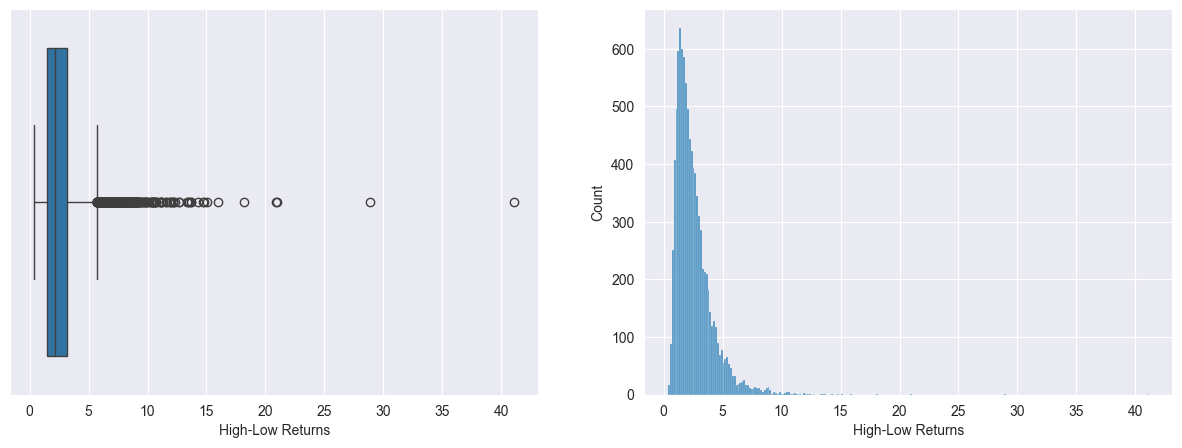

In [333]:
draw_plots(df_microsoft_daily, "High-Low Returns")

In [334]:
show_tab(outliers, df_microsoft_daily['High-Low Returns'])

----------------------------  -----
Kwartyl dolny Q1:              1.46
Kwartyl górny Q3:              3.15
Odstęp międzykwartylowy IQR:   1.69
Lewy wąs:                     -1.08
Prawy wąs:                     5.68
----------------------------  -----


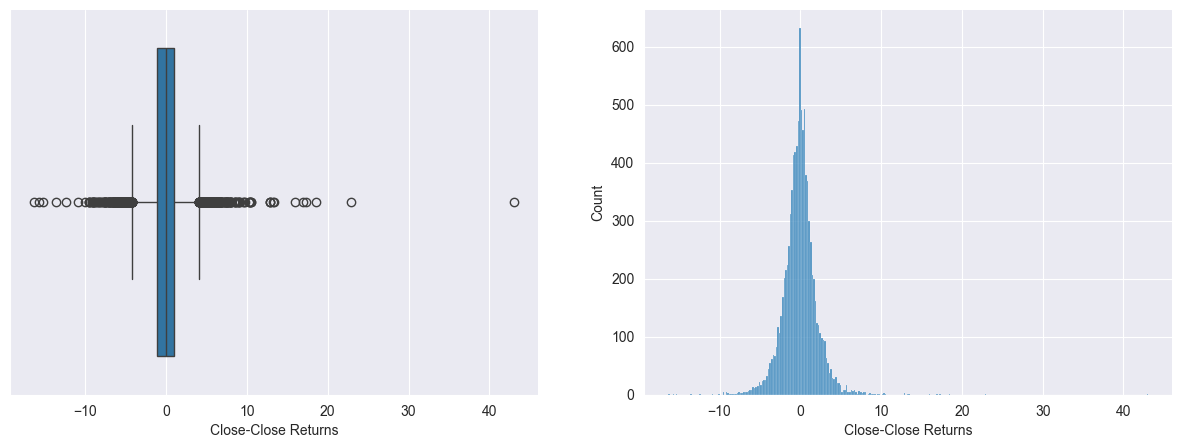

In [335]:
draw_plots(df_microsoft_daily, "Close-Close Returns")

In [336]:
show_tab(outliers,df_microsoft_daily["Close-Close Returns"] )

----------------------------  -----
Kwartyl dolny Q1:             -1.12
Kwartyl górny Q3:              0.93
Odstęp międzykwartylowy IQR:   2.05
Lewy wąs:                     -4.19
Prawy wąs:                     4
----------------------------  -----


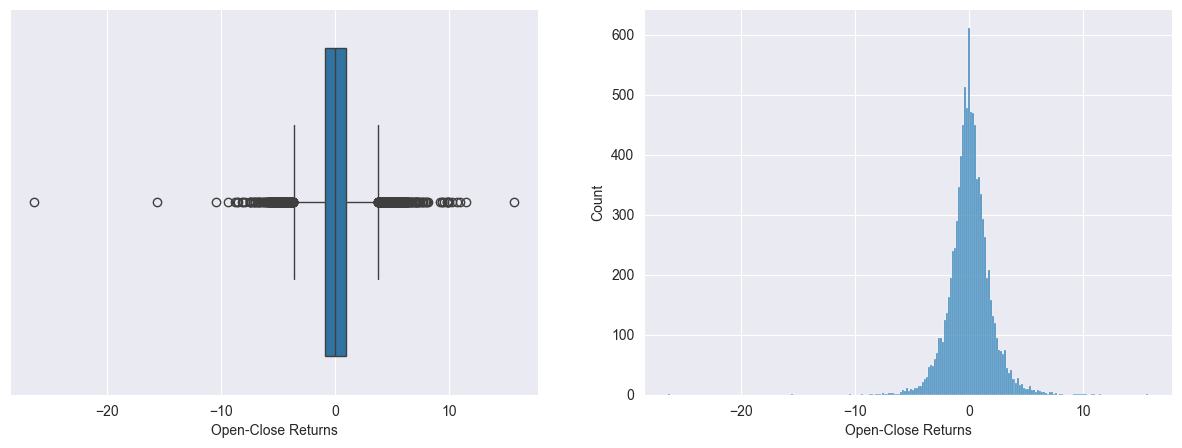

In [337]:
draw_plots(df_microsoft_daily, "Open-Close Returns")

In [338]:
show_tab(outliers,df_microsoft_daily["Open-Close Returns"] )

----------------------------  -----
Kwartyl dolny Q1:             -0.86
Kwartyl górny Q3:              0.99
Odstęp międzykwartylowy IQR:   1.85
Lewy wąs:                     -3.64
Prawy wąs:                     3.76
----------------------------  -----


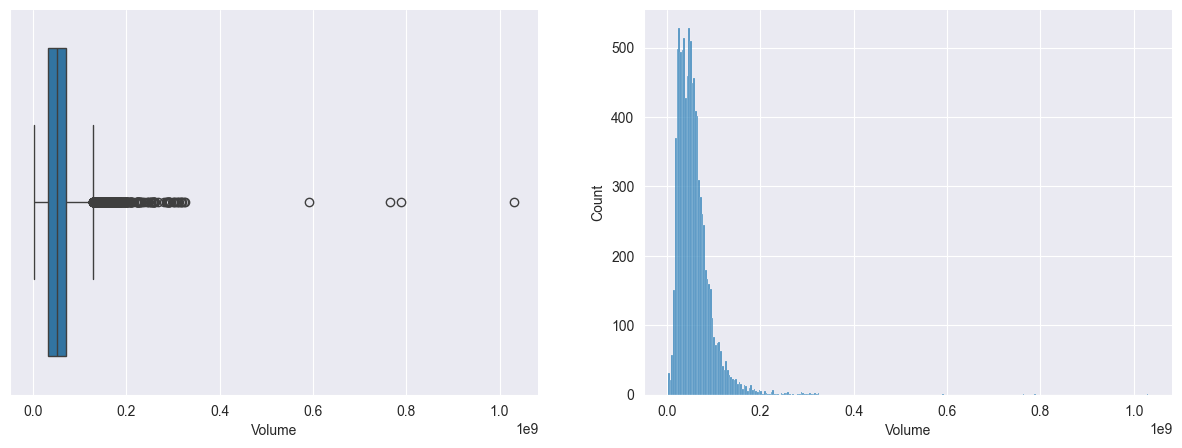

In [339]:
draw_plots(df_microsoft_daily,'Volume')

In [340]:
show_tab(outliers, df_microsoft_daily['Volume'])

----------------------------  ------------
Kwartyl dolny Q1:              3.29356e+07
Kwartyl górny Q3:              7.1218e+07
Odstęp międzykwartylowy IQR:   3.82824e+07
Lewy wąs:                     -2.4488e+07
Prawy wąs:                     1.28642e+08
----------------------------  ------------


Szczegółowa analiza wybranych cech tabeli microsoft_daily.db

Wyznaczanie współczynników
W celu wyznaczenia odpowiednich współczynników, możemy skorzystać z poniższych wzorów.

Wartość średnia: 
$m = E(X) = $
...

Nie będę natomiast korzystał z tych wzorów ponieważ, powyższe współczynniki można obliczyć przez wbudowane metody i funkcjew w bibliotekach numpy i scipy

Funckje pomocnicze

Funckja która pomoże wyznaczyć wskaźniki położenia

In [341]:
def pos_indicators(values):
    min_ = values.min()
    max_ = values.max()
    Q1 = values.quantile(.25)
    Q3 = values.quantile(.75)
    modes_res = stats.mode(values)
    modes = modes_res[0]
    counts = modes_res[1]
    max_count = counts.max()
    
    res = [
        ('Najmniejsza wartość (min)', fun(min_)),
        ('Największa wartość (max)', fun(max_)),
        ('Średnia arytmetyczna', fun(values.mean())),
        ('Kwantyl pierwszy (Q1)', fun(Q1)),
        ('Mediana (Q2)', fun(values.median())),
        ('Kwantyl trzeci (Q3)', fun(Q3)),
    ]
    
    return res

Funkcja pozwoli obliczyć wskaźnik rozproszenia

In [342]:
def scatter_indicators(values):
    std = values.std()
    min_ = values.min()
    max_ = values.max()
    Q1 = values.quantile(.25)
    Q3 = values.quantile(.75)
    IQR = Q3 - Q1
    Q = IQR / 2
    skew = round(stats.skew(values), 2)
    skew_msg = 'prawostronnie skośny' if skew > 0 else 'lewostronnie skośny' if skew < 0 else 'symetryczny'
    excess_kurtosis = stats.kurtosis(values)
    kurtosis = excess_kurtosis + 3
    kurtosis_msg = 'leptokurtyczny' if excess_kurtosis > 0 else 'platykurtyczny' if excess_kurtosis < 0 else 'mezokurtyczny'
    
    return [
        ('Odchylenie standardowe', fun(std)),
        ('Wariancja', fun(std ** 2)),
        ('Rozstęp między skrajnymi wartościami (max - min)', fun(max_ - min_)),
        ('Rozstęp międzykwartylowy (IQR)', fun(IQR)),
        ('Odchylenie ćwiartkowe', fun(Q)),
        ('Współczynnik asymetrii (skośności)', f"{fun(skew)} ({skew_msg})"),
        ('Kurtoza', fun(kurtosis)),
        ('Współczynnik wyostrzenia', f'{fun(excess_kurtosis)} ({kurtosis_msg})')
    ]

In [343]:
# dodatkowe statystyki 
def additional_statistics(df):
    all_values = df.count()
    positive_values = (df > 0).sum()
    positive_values_probability = positive_values * 100/ all_values
    avg_positive_return = df[df > 0].mean()
    
    negative_values = (df < 0).sum()
    negative_values_probability = negative_values * 100/ all_values
    avg_negative_return = df[df < 0].mean()
    
    zero_values = (df == 0).sum()
    zero_values_probability = zero_values * 100/ all_values
    
    return [
        ('Liczba wartości pozytywnych:', fun(positive_values)),
        ('Liczba wartosci negatywnych:', fun(negative_values)),
        ('Liczba wystepowania zer:', fun(zero_values)),
        ('Procent dodatnich wartości:', fun(positive_values_probability)),
        ('Procent negatywych wartosci:', fun(negative_values_probability)),
        ('Procent wystepowania zer:', fun(zero_values_probability))
    ]

In [344]:
def compute_intervals_probability(df, no_bins):
    return df.value_counts(normalize=True, bins=no_bins, sort=False)

In [345]:
def compute_cumulative_intervals_probability(intervals_probability):
    return intervals_probability.cumsum()

In [346]:
def count_frequency_intervals(df, no_bins):
    intervals = pd.cut(df, bins=no_bins, include_lowest=True)

    counter = intervals.value_counts(sort=False)
    return counter

In [347]:
def plot_pie_chart(df):
    
    positive = (df > 0).sum()
    negative = (df < 0).sum()
    zero = (df == 0).sum()
    
    labels = ['Pozytywne', 'Negatywne', 'Zera']
    sizes = [positive, negative, zero]
    colors = ['green', 'red', 'blue']
    
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Rozkład procentowy wartości pozytywnych, negatywnych i zer')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

Funkcja wypisująca wyniki w postaci tabeli:

Dystrybucja zmiennej Close-Close Returns

In [348]:
def distribution_chart(df_data, statistic_data, no_bins):
    g = sns.displot(data=df_data, kde=True, bins=no_bins)
    g.fig.set_figwidth(15)
    g.fig.set_figheight(6.5)
    plt.axvline(statistic_data.median(), color='red', linestyle='dashed', linewidth=2, label='Średnia')
    plt.axvline(statistic_data.median(), color='green', linestyle='dashed', linewidth=2, label='Mediana')
    plt.axvline(statistic_data.median() + df_data.std(), color='orange', linestyle='dashed', linewidth=1, label='Średnia + 1SD')
    plt.axvline(statistic_data.median() - df_data.std(), color='orange', linestyle='dashed', linewidth=1, label='Średnia - 1SD')
    plt.axvline(statistic_data.median() + 2*df_data.std(), color='blue', linestyle='dashed', linewidth=1, label='Średnia + 2SD')
    plt.axvline(statistic_data.median() - 2*df_data.std(), color='blue', linestyle='dashed', linewidth=1, label='Średnia - 2SD')
    plt.legend()
    return g

In [368]:
def compare_with_normal_distribution(real_data):
    mean = real_data.mean()
    std = real_data.std()
    simulated_data = np.random.normal(mean, std, size=len(real_data))
   
    plt.figure(figsize=(15,6.5)) 
    
    # Rysowanie wykresu
    sns.kdeplot(real_data, label='Real Data', color='blue')
    sns.kdeplot(simulated_data, label='Simulated Data', color='orange')
    

    # Dodawanie tytułów i etykiet osi
    plt.title('Porównanie Rozkładu Normalnego i Rzeczywistych Danych')
    plt.xlabel('Wartości')
    plt.ylabel('Gęstość')
       
    # Dodawanie legendy
    plt.legend()
    plt.show()

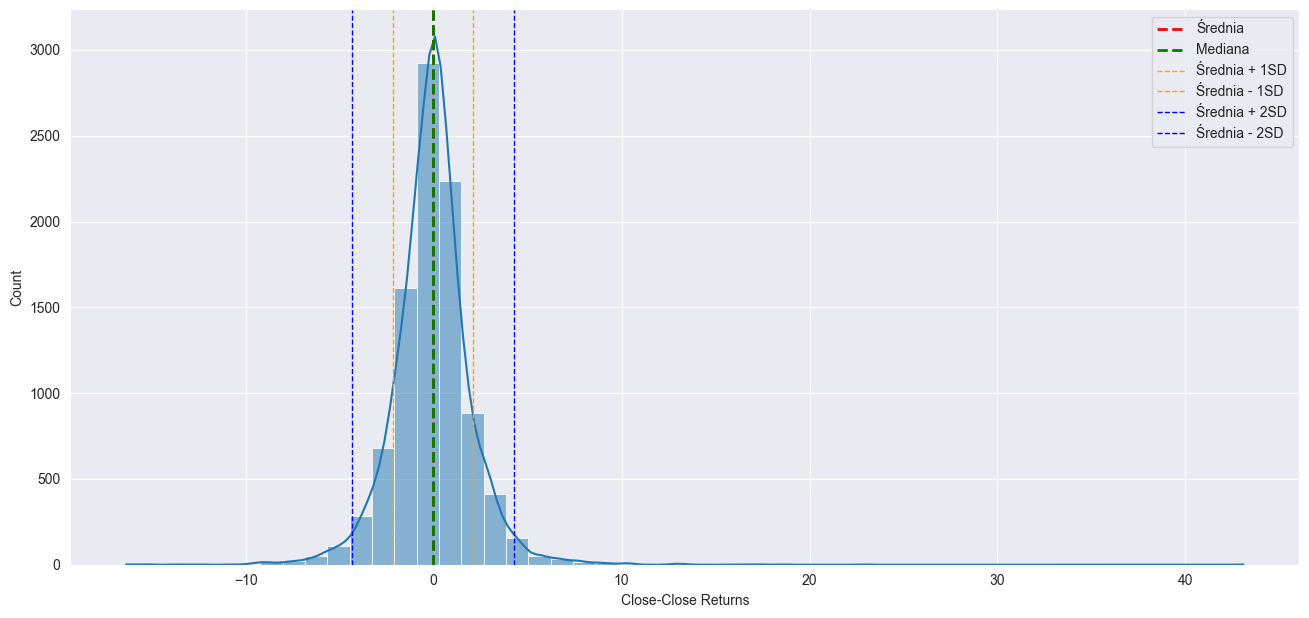

In [369]:
distribution_chart(df_microsoft_daily['Close-Close Returns'],df_microsoft_daily['Close-Close Returns'],50)

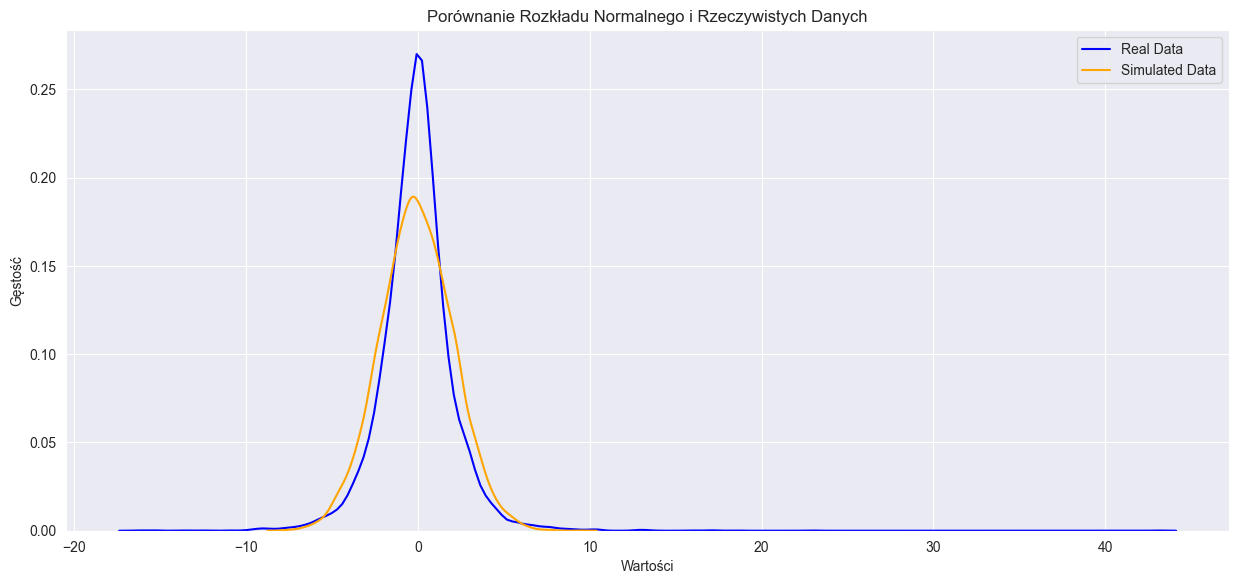

In [370]:
compare_with_normal_distribution(df_microsoft_daily['Close-Close Returns'])

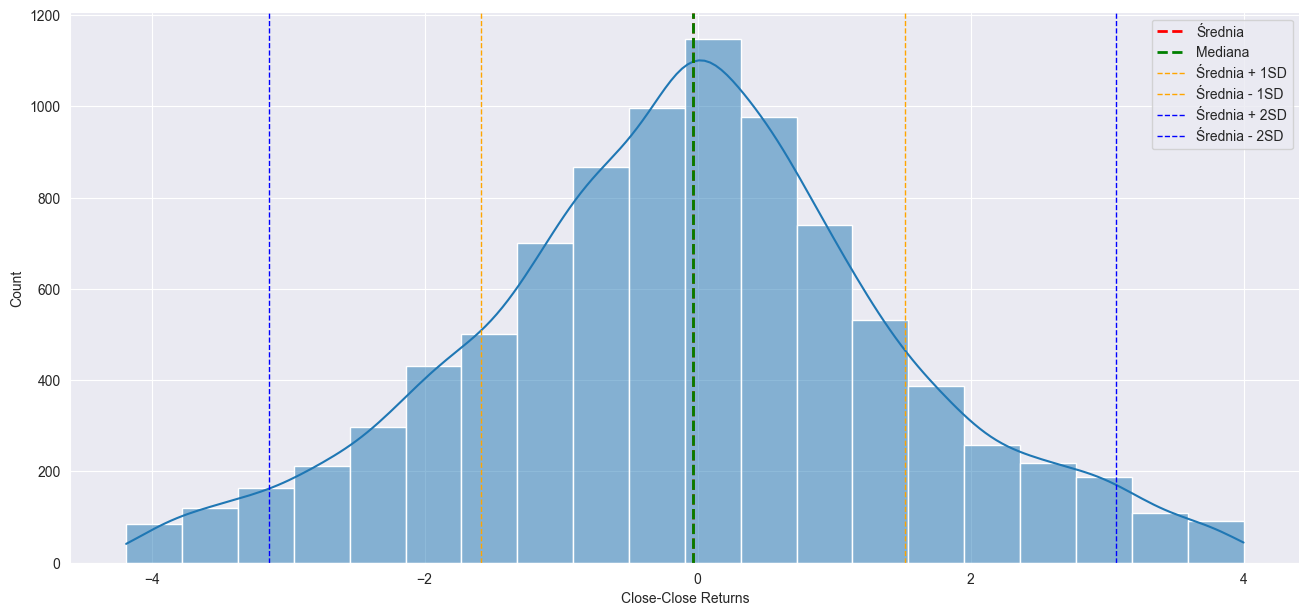

In [350]:
data = df_microsoft_daily['Close-Close Returns']

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR

# Wybieramy wartości pomiędzy left a right
selected_values = data[(data >= left) & (data <= right)]
distribution_chart(selected_values, df_microsoft_daily['Close-Close Returns'],20 )

In [351]:
df_microsoft_daily['Close-Close Returns'] = df_microsoft_daily['Close-Close Returns'].fillna(0)

In [352]:
show_tab(pos_indicators,df_microsoft_daily['Close-Close Returns'])

-------------------------  ------
Najmniejsza wartość (min)  -16.36
Największa wartość (max)    43.09
Średnia arytmetyczna        -0.07
Kwantyl pierwszy (Q1)       -1.12
Mediana (Q2)                -0.04
Kwantyl trzeci (Q3)          0.93
-------------------------  ------


In [353]:
show_tab(scatter_indicators, df_microsoft_daily['Close-Close Returns'])

------------------------------------------------  ---------------------------
Odchylenie standardowe                            2.14
Wariancja                                         4.59
Rozstęp między skrajnymi wartościami (max - min)  59.46
Rozstęp międzykwartylowy (IQR)                    2.05
Odchylenie ćwiartkowe                             1.02
Współczynnik asymetrii (skośności)                1.18 (prawostronnie skośny)
Kurtoza                                           26.87
Współczynnik wyostrzenia                          23.87 (leptokurtyczny)
------------------------------------------------  ---------------------------


In [354]:
intervals_prob = compute_intervals_probability(df_microsoft_daily['Close-Close Returns'],20)
intervals_prob

(-16.424, -13.391]    0.000420
(-13.391, -10.418]    0.000210
(-10.418, -7.445]     0.003043
(-7.445, -4.472]      0.018155
(-4.472, -1.499]      0.169273
(-1.499, 1.474]       0.642880
(1.474, 4.447]        0.146395
(4.447, 7.419]        0.014902
(7.419, 10.392]       0.003358
(10.392, 13.365]      0.000630
(13.365, 16.338]      0.000210
(16.338, 19.311]      0.000315
(19.311, 22.284]      0.000000
(22.284, 25.257]      0.000105
(25.257, 28.23]       0.000000
(28.23, 31.203]       0.000000
(31.203, 34.175]      0.000000
(34.175, 37.148]      0.000000
(37.148, 40.121]      0.000000
(40.121, 43.094]      0.000105
Name: proportion, dtype: float64

In [355]:
compute_cumulative_intervals_probability(intervals_prob)

(-16.424, -13.391]    0.000420
(-13.391, -10.418]    0.000630
(-10.418, -7.445]     0.003673
(-7.445, -4.472]      0.021828
(-4.472, -1.499]      0.191101
(-1.499, 1.474]       0.833980
(1.474, 4.447]        0.980376
(4.447, 7.419]        0.995278
(7.419, 10.392]       0.998636
(10.392, 13.365]      0.999265
(13.365, 16.338]      0.999475
(16.338, 19.311]      0.999790
(19.311, 22.284]      0.999790
(22.284, 25.257]      0.999895
(25.257, 28.23]       0.999895
(28.23, 31.203]       0.999895
(31.203, 34.175]      0.999895
(34.175, 37.148]      0.999895
(37.148, 40.121]      0.999895
(40.121, 43.094]      1.000000
Name: proportion, dtype: float64

In [371]:
# Rysujemy dystrybuantę
def distribuant(data):
    plt.figure(figsize=(15,6.5)) 
    sns.ecdfplot(data)
    # Dodajemy tytuł i opis osi
    plt.title('Dystrybuanta')
    plt.xlabel('Procentowe wartosci zwrotów')
    plt.ylabel('Prawdopodobieństwo kumulatywne')
    plt.show()

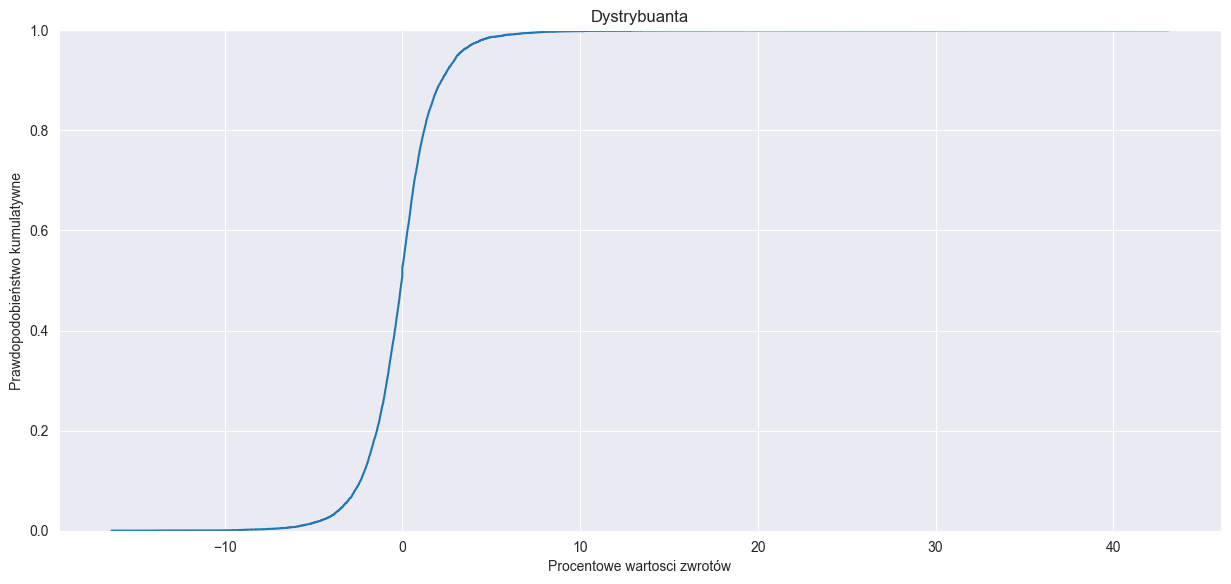

In [372]:
distribuant(df_microsoft_daily['Close-Close Returns'])

In [357]:
count_frequency_intervals(df_microsoft_daily['Close-Close Returns'],20)

Close-Close Returns
(-16.424, -13.391]       4
(-13.391, -10.418]       2
(-10.418, -7.445]       29
(-7.445, -4.472]       173
(-4.472, -1.499]      1613
(-1.499, 1.474]       6126
(1.474, 4.447]        1395
(4.447, 7.419]         142
(7.419, 10.392]         32
(10.392, 13.365]         6
(13.365, 16.338]         2
(16.338, 19.311]         3
(19.311, 22.284]         0
(22.284, 25.257]         1
(25.257, 28.23]          0
(28.23, 31.203]          0
(31.203, 34.175]         0
(34.175, 37.148]         0
(37.148, 40.121]         0
(40.121, 43.094]         1
Name: count, dtype: int64

In [358]:
show_tab(additional_statistics,df_microsoft_daily['Close-Close Returns'])

----------------------------  -------
Liczba wartości pozytywnych:  4497
Liczba wartosci negatywnych:  4820
Liczba wystepowania zer:       212
Procent dodatnich wartości:     47.19
Procent negatywych wartosci:    50.58
Procent wystepowania zer:        2.22
----------------------------  -------


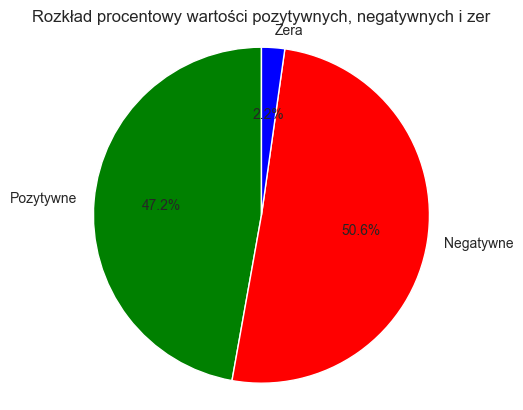

In [359]:
plot_pie_chart(df_microsoft_daily['Close-Close Returns'])